<a href="https://colab.research.google.com/github/romenmeitei/Dengue-cases-in-Manipur/blob/main/Correlation_analysis_VIF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Missing Values:
 Time                         0
Total Cases                  0
IgM Mac ELISA Postive        0
NS1 Antigen ELISA Postive    0
Temperature (°C)             0
Precipitation (mm)           0
NDVI                         0
dtype: int64

Summary Statistics:
                       Time  Total Cases  IgM Mac ELISA Postive  \
count                   72    72.000000              72.000000   
mean   2021-12-15 22:40:00    23.204861              13.138889   
min    2019-01-01 00:00:00     0.000000               0.000000   
25%    2020-06-23 12:00:00     1.000000               0.000000   
50%    2021-12-16 12:00:00     8.000000               7.000000   
75%    2023-06-08 12:00:00    32.250000              22.000000   
max    2024-12-01 00:00:00    79.125000              55.000000   
std                    NaN    29.960584              16.110801   

       NS1 Antigen ELISA Postive  Temperature (°C)  Precipitation (mm)  \
count                  72.000000      7.200000e+01        7.20

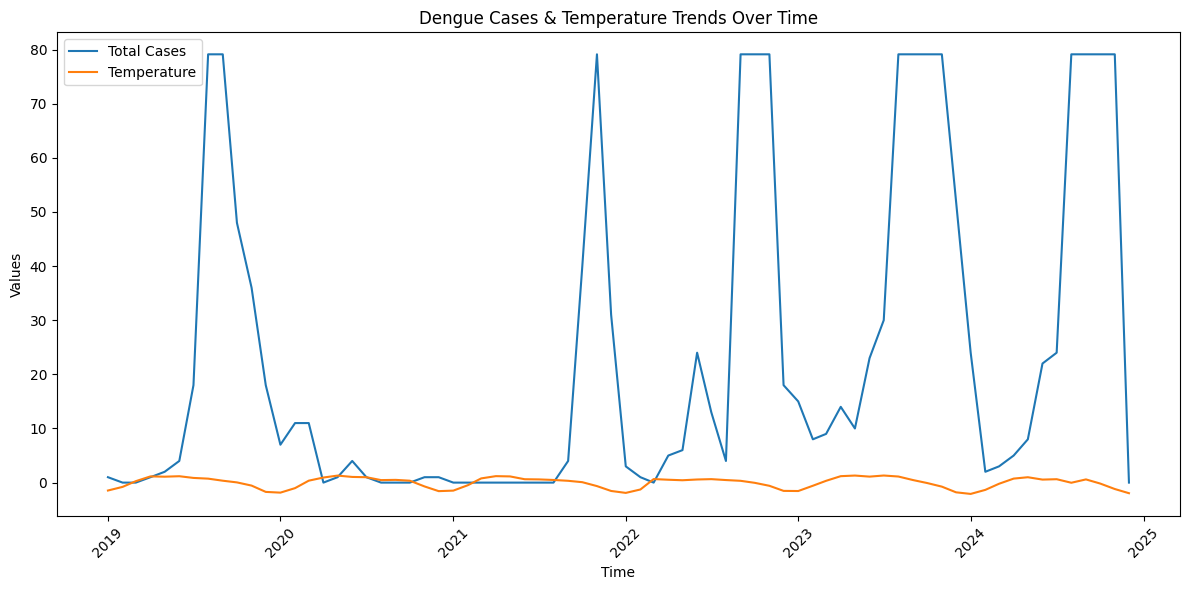

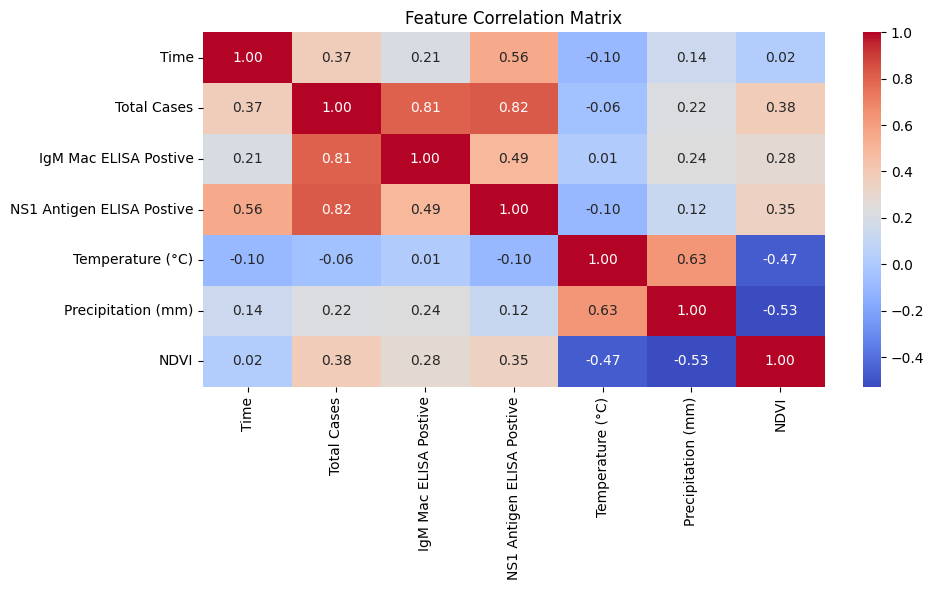


ANCOVA Results:
                            df        sum_sq       mean_sq          F  \
Q('Temperature (°C)')     1.0    197.228666    197.228666   0.359057   
Q('Precipitation (mm)')   1.0   7070.028672   7070.028672  12.871049   
Q('NDVI')                 1.0  19112.742888  19112.742888  34.794915   
Residual                 68.0  37352.196822    549.297012        NaN   

                               PR(>F)  
Q('Temperature (°C)')    5.510219e-01  
Q('Precipitation (mm)')  6.241366e-04  
Q('NDVI')                1.276990e-07  
Residual                          NaN  

Variance Inflation Factor (VIF):
               Feature       VIF
0               const  1.000000
1    Temperature (°C)  1.739216
2  Precipitation (mm)  1.871237
3                NDVI  1.452852

Model Performance:
MSE: 397.1486288399327
R² Score: 0.4482357682323822


In [5]:
# ---- Import Required Libraries ----
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ---- Load Datasets ----
df_climate = pd.read_csv("/content/generated_climate_data.csv")
df_cases = pd.read_excel("Final Dataset.xlsx", sheet_name="Sheet")

# ---- Date Conversion ----
month_mapping = {
    'Jan': '01', 'Feb': '02', 'March': '03', 'April': '04', 'May': '05', 'June': '06',
    'July': '07', 'Aug': '08', 'Sept': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'
}
df_cases['Months'] = df_cases['Months'].map(month_mapping)
df_cases['Time'] = df_cases['Year'].astype(str) + '-' + df_cases['Months']
df_cases.drop(columns=['Year', 'Months'], inplace=True)

# ---- Aggregate Cases per Month ----
df_cases_agg = df_cases.groupby("Time")[["Total Cases", "IgM Mac ELISA Postive", "NS1 Antigen ELISA Postive"]].sum().reset_index()

# ---- Merge with Climate Data ----
final_df = pd.merge(df_cases_agg, df_climate, on="Time", how="left")
final_df['Time'] = pd.to_datetime(final_df['Time'])
final_df["Total Cases"] = final_df["Total Cases"].astype(float)

# ---- Handle Outliers with IQR (Winsorization) ----
numeric_cols = final_df.select_dtypes(include=["float64", "int64"]).columns
Q1 = final_df[numeric_cols].quantile(0.25)
Q3 = final_df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
final_df[numeric_cols] = final_df[numeric_cols].clip(lower=lower_bound, upper=upper_bound, axis=1)

# ---- Standardize Climate Features ----
features = ["Temperature (°C)", "Precipitation (mm)", "NDVI"]
scaler = StandardScaler()
final_df[features] = scaler.fit_transform(final_df[features])

# ---- Summary Statistics ----
print("Missing Values:\n", final_df.isnull().sum())
print("\nSummary Statistics:\n", final_df.describe())

# ---- EDA: Line Plot ----
plt.figure(figsize=(12, 6))
sns.lineplot(data=final_df, x="Time", y="Total Cases", label="Total Cases")
sns.lineplot(data=final_df, x="Time", y="Temperature (°C)", label="Temperature")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.title("Dengue Cases & Temperature Trends Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ---- Correlation Heatmap ----
plt.figure(figsize=(10, 6))
sns.heatmap(final_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

# ---- ANCOVA ----
model = ols("Q('Total Cases') ~ Q('Temperature (°C)') + Q('Precipitation (mm)') + Q('NDVI')", data=final_df).fit()
ancova_table = anova_lm(model)
print("\nANCOVA Results:\n", ancova_table)

# ---- VIF Calculation (Multicollinearity Check) ----
X_vif = add_constant(final_df[["Temperature (°C)", "Precipitation (mm)", "NDVI"]])
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print("\nVariance Inflation Factor (VIF):\n", vif_data)

# ---- Linear Regression (Model Validation) ----
X = final_df[["Temperature (°C)", "Precipitation (mm)", "NDVI"]]
y = final_df["Total Cases"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("\nModel Performance:")
print("MSE:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))


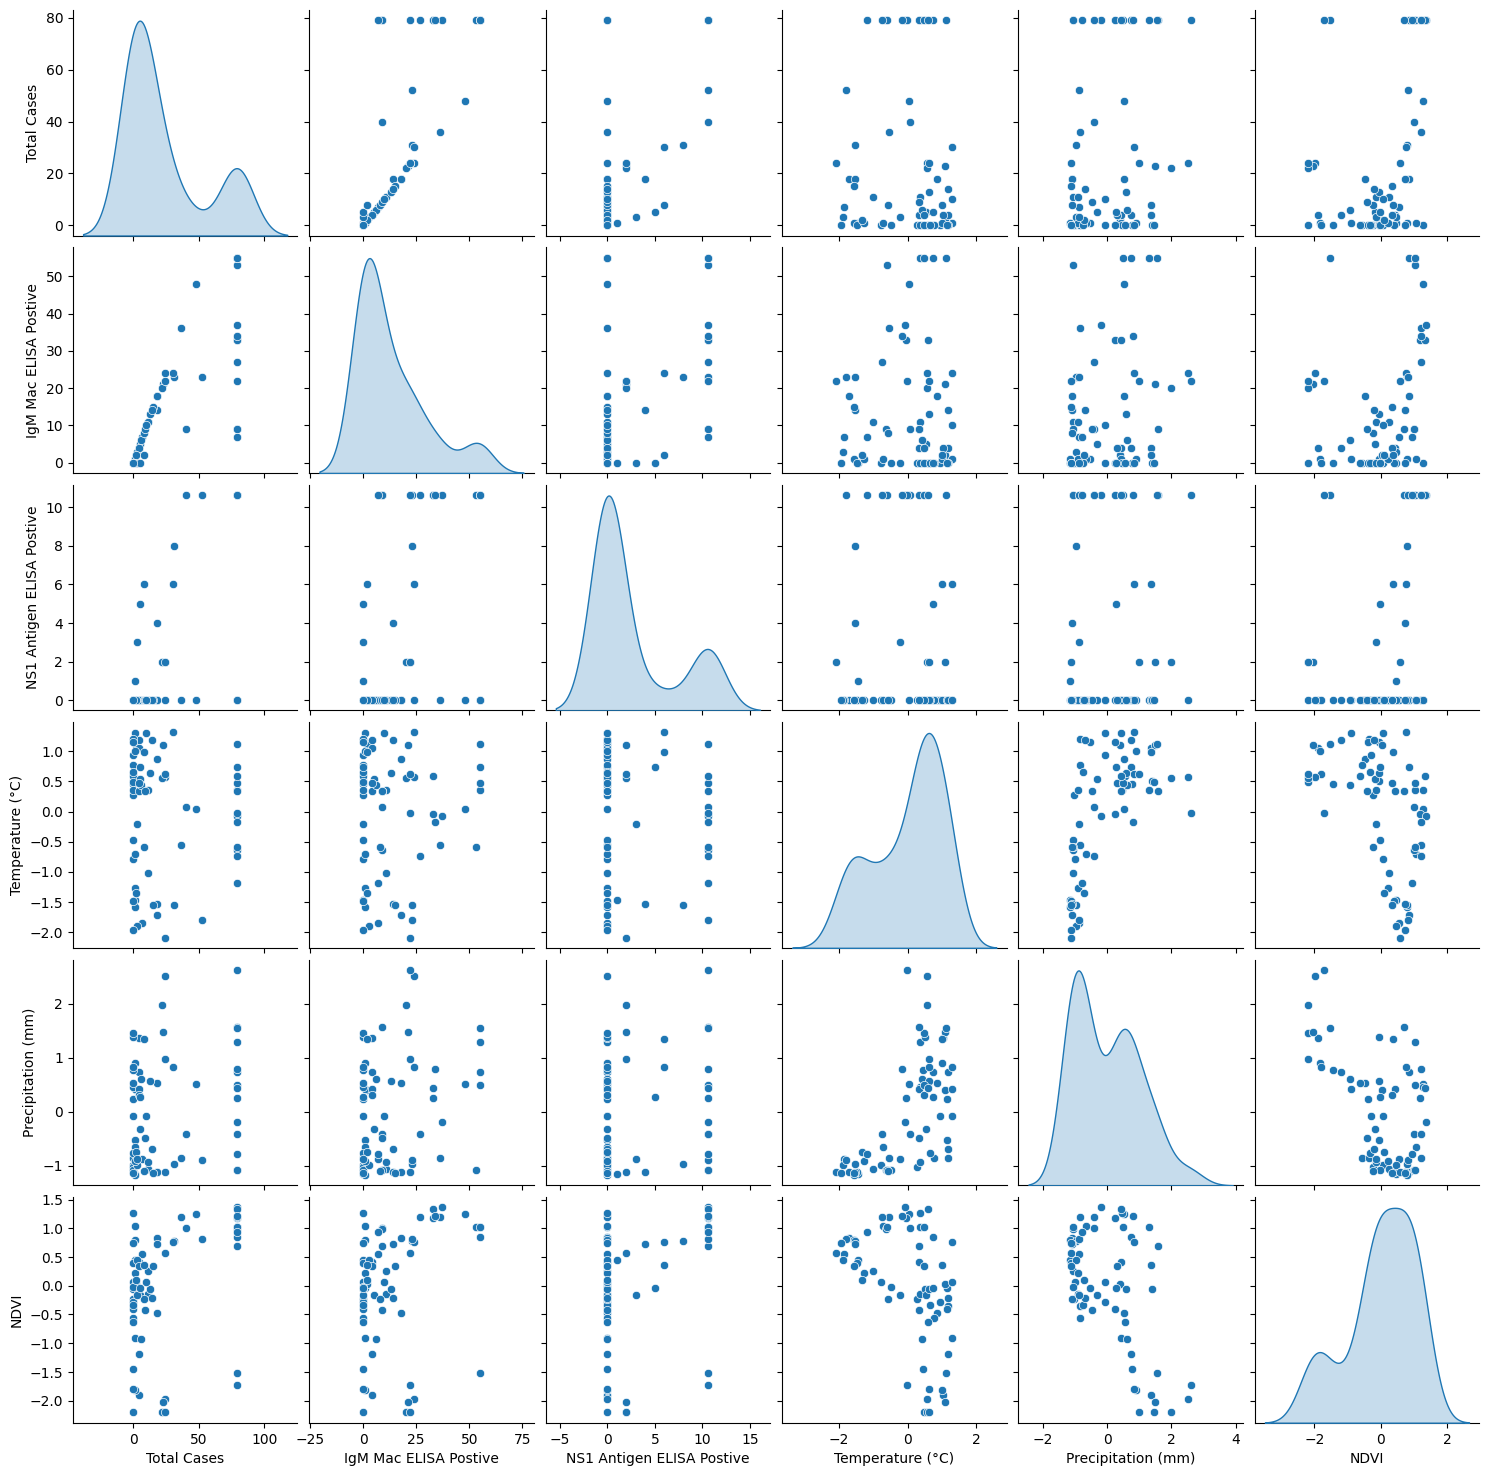

In [8]:
sns.pairplot(final_df, diag_kind='kde')
plt.show()


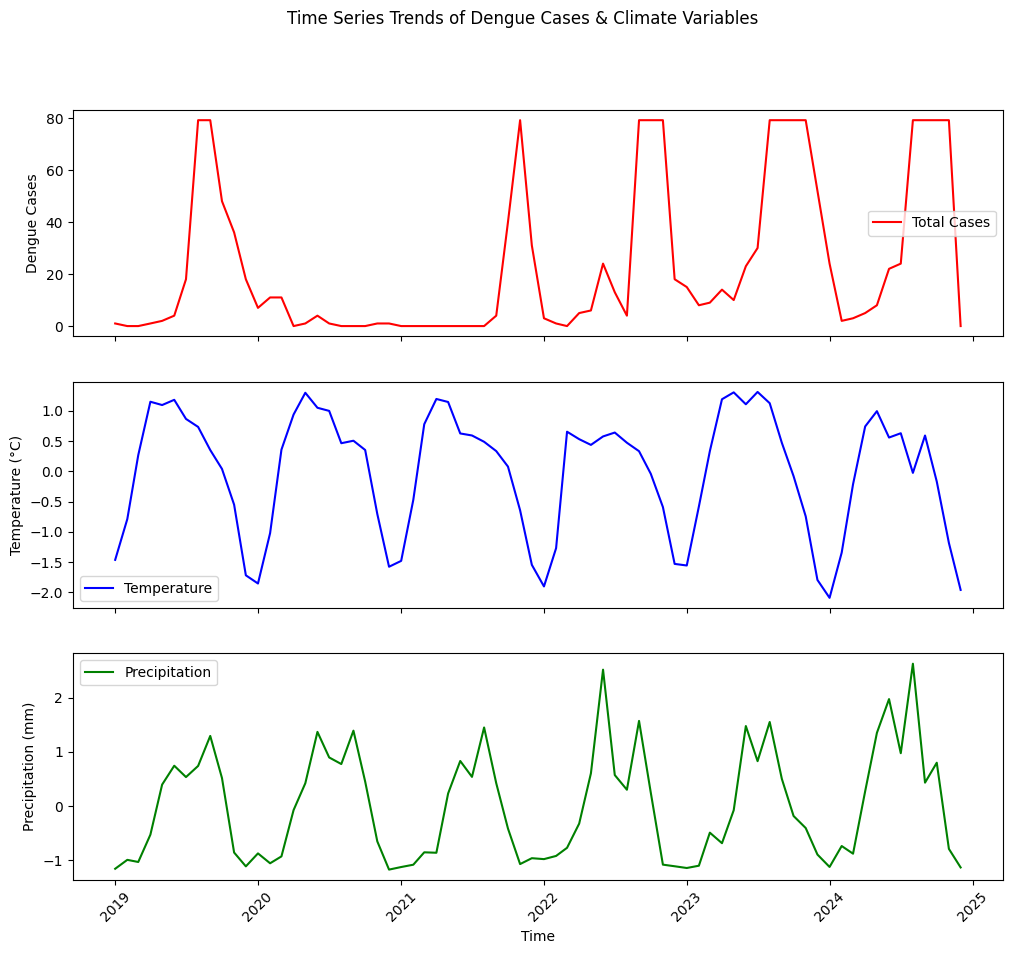

In [3]:
fig, ax = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
sns.lineplot(ax=ax[0], data=final_df, x="Time", y="Total Cases", label="Total Cases", color="red")
sns.lineplot(ax=ax[1], data=final_df, x="Time", y="Temperature (°C)", label="Temperature", color="blue")
sns.lineplot(ax=ax[2], data=final_df, x="Time", y="Precipitation (mm)", label="Precipitation", color="green")

ax[0].set_ylabel("Dengue Cases")
ax[1].set_ylabel("Temperature (°C)")
ax[2].set_ylabel("Precipitation (mm)")
plt.xlabel("Time")
plt.xticks(rotation=45)
plt.suptitle("Time Series Trends of Dengue Cases & Climate Variables")
plt.show()


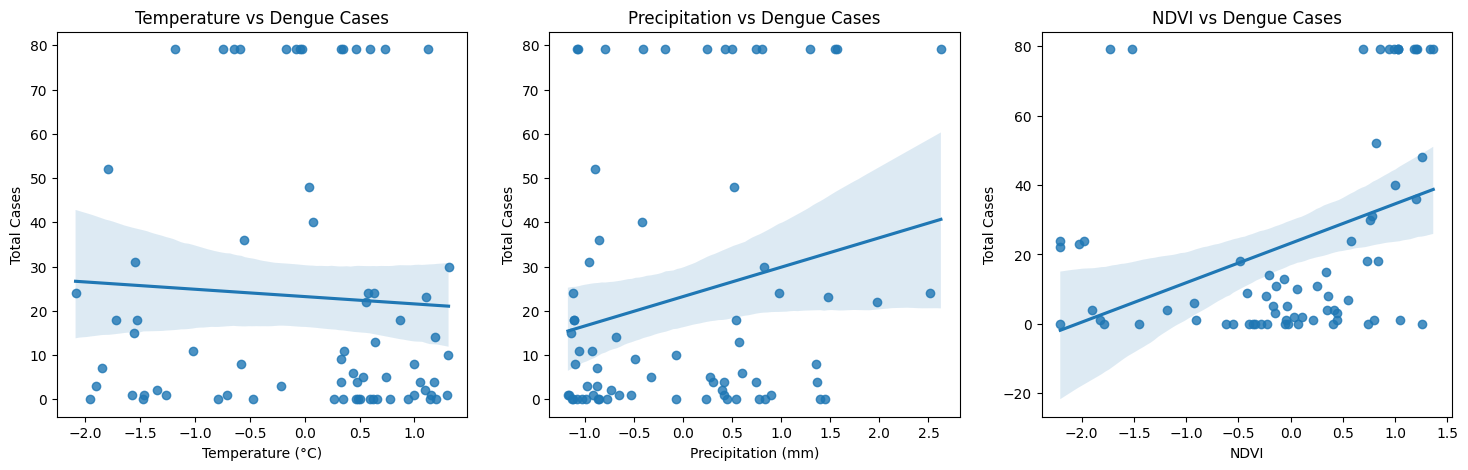

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.regplot(ax=axes[0], x=final_df["Temperature (°C)"], y=final_df["Total Cases"])
sns.regplot(ax=axes[1], x=final_df["Precipitation (mm)"], y=final_df["Total Cases"])
sns.regplot(ax=axes[2], x=final_df["NDVI"], y=final_df["Total Cases"])

axes[0].set_title("Temperature vs Dengue Cases")
axes[1].set_title("Precipitation vs Dengue Cases")
axes[2].set_title("NDVI vs Dengue Cases")
plt.show()
